# Matrix-vector products with Toeplitz and Circulant matrices

This notebook illustrates algorithms for computing the matrix-vector product for the cases in which the matrix is Toeplitz or Circulant.

#### References

* Jain, A. K. (1989), Fundamentals of Digital Image Processing, Prentice Hall, ISBN 978-0-13-336165-0.

* Horn, R. A. and C. R. Johnson, (1991), Topics in Matrix Analysis, Cambridge University Press, ISBN 978-0-521-46713-1.

* Chan, R. H. and X-Q Jin (2007), An introduction to iterative Toeplitz solvers, Philadelphia: Society for Industrial and Applied Mathematics, ISBN 978-0-898716-36-8. 

* Golub, G. H. and C. F. Van Loan, (2013), Matrix computations, 4th edition, Johns Hopkins University Press, ISBN 978-1-4214-0794-4.

## Topics

* [Circulant matrices](#sec1)

    * [Circulant matrices are diagonalized by the Fourier matrix](#sec1a)

    * [Product of a Circulant matrix $\mathbf{C}$ and an arbitrary vector $\mathbf{v}$](#sec1b)

* [Toeplitz matrices](#sec2)

    * [Arbitrary Toeplitz matrices are not diagonalized by the Fourier matrix](#sec2a)
    
    * [The Fourier approach used for circulant matrices is not valid for the product of arbitrary Toeplitz matrices and arbitrary vectors](#sec2b)
    
    * [The Fourier approach used for circulant matrices is valid for the product of some particular Toeplitz matrices and some particular vectors](#sec2c)
   
* [Arbitrary $N \times N$ Toeplitz matrices can be embedded into $2N \times 2N$ circulant matrices](#sec3)

    * [Product of an arbitrary Toeplitz matrix $\mathbf{T}$ and an arbitrary vector $\mathbf{w}$](#sec3a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, circulant, dft
from scipy.fft import fft, ifft, fft2, ifft2

<a id='sec1'></a>
## Circulant matrices

A $N \times N$ **circulant** matrix $\mathbf{C}$ is a particular Toeplitz matrix that can be defined in terms of its first column $\mathbf{c}_{0}$, as follows:

<a id='eq1'></a>
$$
\mathbf{C} = c_{00} \, \mathbf{I} + c_{10} \, \mathbf{D} + c_{20} \, \mathbf{D}^{2} + ... + c_{(N-1)0} \, \mathbf{D}^{N-1} \: , \tag{1}
$$

where $\mathbf{I}$ is the identity matrix and $\mathbf{D}$ is the *downshift permutation matrix* (Golub and Van Loan, 2013, p. 220). For $N = 4$, the downshift permutation matrix is given by:

<a id='eq2a'></a>
$$
\mathbf{D} = \begin{bmatrix}
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix} \quad , \tag{2a}
$$

<a id='eq2b'></a>
$$
\mathbf{D}^{2} = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix} \quad , \tag{2b}
$$

<a id='eq2c'></a>
$$
\mathbf{D}^{3} = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0
\end{bmatrix} \quad . \tag{2c}
$$

In [2]:
x = np.arange(5)
print(x)

[0 1 2 3 4]


In [3]:
D = np.roll(np.identity(5), shift=1, axis=0)

In [4]:
print(D)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [5]:
print(np.dot(D, x))

[4. 0. 1. 2. 3.]


In [6]:
N = 5
#col_C = np.round(2*np.random.rand(N) - 1, decimals=2)
col_C = np.linspace(-1, 1, N)

In [7]:
C = circulant(col_C)

In [8]:
print(C)

[[-1.   1.   0.5  0.  -0.5]
 [-0.5 -1.   1.   0.5  0. ]
 [ 0.  -0.5 -1.   1.   0.5]
 [ 0.5  0.  -0.5 -1.   1. ]
 [ 1.   0.5  0.  -0.5 -1. ]]


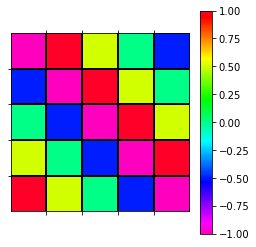

In [9]:
plt.close('all')
plt.matshow(C, vmin = -1, vmax = 1, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

<a id='sec1a'></a>
### Circulant matrices are diagonalized by the Fourier matrix

The eigenvalues of a [**circulant matrix**](https://en.wikipedia.org/wiki/Circulant_matrix) can be computed by using the 1D Discrete Fourier Transform (DFT).

Let's consider a $N \times 1$ data vector $\mathbf{d}$. The DFT of $\tilde{\mathbf{d}}$ can be computed as follows:

<a id='eq3a'></a>
$$
\tilde{\mathbf{d}} = \mathbf{H} \, \mathbf{d} \: , \tag{3a}
$$

where 

<a id='eq3b'></a>
$$
\mathbf{H} = \tfrac{1}{\sqrt{N}} \, \mathbf{F}_{N} \quad . \tag{3b}
$$

In [10]:
H = dft(N, scale='sqrtn')

Here, we compute the DFT by using the scale factor $\tfrac{1}{\sqrt{N}}$, where $N$ is the number of data.

This scale factor makes the DFT matrix $\mathbf{H}$ ([equation 3b](#eq3b)) [**unitary**](https://en.wikipedia.org/wiki/Unitary_matrix), with inverse given by $\mathbf{H}^{-1} = \mathbf{H}^{H}$, where $\mathbf{H}^{H}$ is its [**conjugate transpose**](https://en.wikipedia.org/wiki/Conjugate_transpose) (see the notebook `fourier_1D_4`).

In [11]:
np.allclose(np.dot(np.conjugate(H).T, H), np.identity(N))

True

Besides, it can be shown that $\mathbf{H}^{H} = \mathbf{H}^{\ast}$ (Golub and Van Loan, 2013), where $\mathbf{H}^{\ast}$ is the [**conjugate matrix**](http://mathworld.wolfram.com/ConjugateMatrix.html) of $\mathbf{H}$.

In [12]:
np.allclose(np.conjugate(H).T, np.conjugate(H))

True

In this case, the product $\mathbf{H}^{\ast}\mathbf{H} = \mathbf{H}\mathbf{H}^{\ast} = \mathbf{I}$

In [13]:
np.allclose(np.dot(np.conjugate(H), H), np.identity(N))

True

As a consequence, the Inverse Discrete Fourier Transform (IDFT) can be defined as follows:

<a id='eq4'></a>
$$
\mathbf{d} = \mathbf{H}^{\ast} \tilde{\mathbf{d}} \: . \tag{4}
$$

It can be shown that the DFT matrix $\mathbf{H}$ ([equation 3b](#eq3b)) diagonalizes a circulant matrix $\mathbf{C}$ ([equation 1](#eq1)). It means that the matrix $\mathbf{C}$ satisfies the following equation:

<a id='eq5'></a>
$$
\mathbf{C} = \mathbf{H}^{\ast}\boldsymbol{\Lambda}\mathbf{H} \: , \tag{5}
$$

where $\boldsymbol{\Lambda}$ is a diagonal matrix containing the eigenvalues of $\mathbf{C}$.

By properly manipulating the [equation 5](#eq5), 

$$
\begin{split}
\mathbf{H} \, \mathbf{C} &= \boldsymbol{\Lambda} \, \mathbf{H} \\
\mathbf{H} \, \mathbf{C} \, \mathbf{u}_{0} &= \boldsymbol{\Lambda} \, \mathbf{H} \, \mathbf{u}_{0} \\
\mathbf{H} \, \mathbf{c}_{0} &= \boldsymbol{\Lambda} \, \frac{1}{\sqrt{N}}\mathbf{1}_{N} \\
\end{split} \quad ,
$$

which results in the following equation:

<a id='eq6'></a>
$$
\sqrt{N} \, \mathbf{H} \, \mathbf{c}_{0} = \boldsymbol{\lambda}
\quad , \tag{6}
$$

where $\mathbf{u}_{0}$ is an $N \times 1$ vector with first element equal to $1$ and all the remaining elements equal to $0$, $\mathbf{c}_{0}$ is the first column of $\mathbf{C}$, $\mathbf{1}_{N}$ is an $N \times 1$ with all elements equal to 1 and $\boldsymbol{\lambda}$ is a vector containing the diagonal of $\boldsymbol{\Lambda}$ (the eigenvalues of $\mathbf{C}$).

[Equation 6](#eq6) shows that the eigenvalues of $\mathbf{C}$ can be computed as the DFT of its first column.

In [14]:
# vector containing the eigenvalues of C
lambda_C = np.sqrt(N)*np.dot(H, C[:,0])

In [15]:
# diagonal matrix containing the eigenvalues of C
Lambda_C = np.diag(lambda_C)

In [16]:
# alternative C
C2 = np.linalg.multi_dot([np.conjugate(H), Lambda_C, H]).real

In [17]:
# compare the original circulant matrix C and its alternative form
np.allclose(C, C2)

True

<a id='sec1b'></a>
### Product of a Circulant matrix $\mathbf{C}$ and arbitrary vector $\mathbf{v}$

Let $\mathbf{v}$ be an arbitrary $N \times 1$ vector. From [equation 5](#eq5), we can show that the product of a circulant matrix $\mathbf{C}$ ([equation 1](#eq1)) and an arbitrary vector $\mathbf{v}$ is given by:

<a id='eq7'></a>
$$
\begin{split}
\mathbf{C} \, \mathbf{v} 
&= \mathbf{H}^{\ast} \, \boldsymbol{\Lambda} \, 
\overbrace{\left( \mathbf{H} \, \mathbf{v} \right)}^{\text{DFT of } \mathbf{v}} \\
&= \mathbf{H}^{\ast} 
\underbrace{\left( \boldsymbol{\lambda} \circ \tilde{\mathbf{v}} \right)}_{\text{Hadamard product}}
\end{split} \quad . \tag{7}
$$

As we can see, the product $\mathbf{C} \, \mathbf{v}$ is the IDFT of $\boldsymbol{\lambda} \circ \tilde{\mathbf{v}}$, where $\boldsymbol{\lambda}$ is the vector containing the eigenvalues of $\mathbf{C}$ and $\tilde{\mathbf{v}}$ is the DFT of $\mathbf{v}$.

In [18]:
# create a vector v
v = np.random.rand(N)

# compute the product of C and v
C_v_matvec = np.dot(C, v)

# compute the DFT of v
DFT_v = np.dot(H, v)

# compute the product of IDFT matrix and the vector obtained from 
# the Hadamard product of the vetor lambda_C (containing the eigenvalues of C)
# and the DFt of v
C_v_DFT = np.dot(np.conjugate(H), lambda_C*DFT_v)

In [19]:
np.allclose(C_v_matvec, C_v_DFT)

True

<a id='sec2'></a>
## Toeplitz matrices

Matrices whose entries are constant along each diagonal arise in many applications and are called **Toeplitz** matrices. A $4 \times 4$ Toeplitz matrix $\mathbf{T}$ can be represented as follows:

<a id='eq8'></a>
$$
\mathbf{T} = \begin{bmatrix}
t_{00} & t_{01} & t_{02} & t_{03} \\
t_{10} & t_{00} & t_{01} & t_{02} \\
t_{20} & t_{10} & t_{00} & t_{01} \\
t_{30} & t_{20} & t_{10} & t_{00}
\end{bmatrix} \quad . \tag{8}
$$

In [20]:
N = 10
col_T = np.linspace(3, 10, N)
row_T = np.linspace(10, 20, N)

In [21]:
T = toeplitz(col_T, row_T)

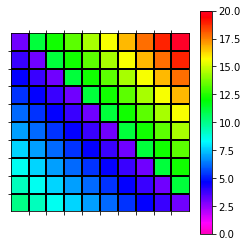

In [22]:
plt.close('all')
plt.matshow(T, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

<a id='sec2a'></a>
### Arbitrary Toeplitz matrices are not diagonalized by the Fourier matrix

Differently from circulant matrices ([equation 1](#eq1)), arbitrary $N \times N$ Toeplitz matrices $\mathbf{T}$ are not diagonalized by the Fourier matrix $\mathbf{H}$. It means that we cannot write an [equation 5](#eq5) for the Toeplitz matrix $\mathbf{T}$, in which the elements of the diagonal matrix $\boldsymbol{\Lambda}$ are obtained by computing the Fourier transform of the first column of $\mathbf{T}$, according to [equation 6](#eq6). In order to illustrate this issue, consider the matrix $\mathbf{T}^{\prime}$ given by:

<a id='eq9'></a>
$$
\mathbf{T}^{\prime} = \mathbf{H}^{\ast} \, \boldsymbol{\Lambda}^{\prime} \, \mathbf{H} \: , \tag{9}
$$

where $\boldsymbol{\Lambda}^{\prime}$ is a diagonal matrix. Besides, consider that the diagonal of $\boldsymbol{\Lambda}^{\prime}$ is defined by the vector $\boldsymbol{\lambda}^{\prime}$:

<a id='eq10'></a>
$$
\boldsymbol{\lambda}^{\prime} = \sqrt{N} \, \mathbf{H} \, \mathbf{t}_{0} \quad , \tag{10}
$$

where $\mathbf{t}_{0}$ is the first column of the $N \times N$ Toeplitz matrix $\mathbf{T}$. The cells below show that matrix $\mathbf{T}^{\prime}$ is different from the Toeplitz matrix $\mathbf{T}$.

In [23]:
# DFT matrix
H = dft(N, scale='sqrtn')

In [24]:
# DFT of the first column of T
lambda_prime = np.sqrt(N)*np.dot(H, T[:,0])

In [25]:
# create a diagonal matrix with the vector computed above
Lambda_prime = np.diag(lambda_prime)

In [26]:
# create a matrix using the diagonal matrix computed above
T_prime = np.linalg.multi_dot([np.conjugate(H), Lambda_prime, H]).real

In [27]:
# compare the original Toepliz matrix T and that computed above
np.allclose(T, T_prime)

False

The cell above shows that $\mathbf{T} \ne \mathbf{T}^{\prime}$.

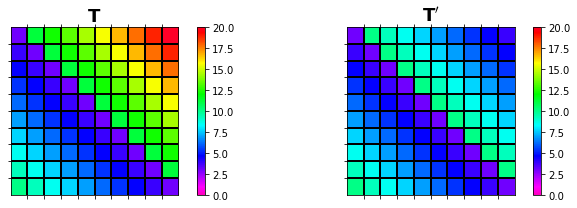

In [28]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.title('$\mathbf{T}$', fontsize=18)
plt.matshow(T, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{T}^{\prime}$', fontsize=18)
plt.matshow(T_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

Notice that only the lower triangle of these matrices are equal to each other.

In [29]:
np.allclose(np.tril(T), np.tril(T_prime))

True

<a id='sec2b'></a>
### The Fourier approach used for circulant matrices is not valid for the product of arbitrary Toeplitz matrices and arbitrary vectors

The cells above show that, for arbitrary Toeplitz matrices $\mathbf{T}$ and vectors $\mathbf{w}$, 

$$
\mathbf{T} \, \mathbf{w} \ne \mathbf{T}^{\prime} \, \mathbf{w} \: ,
$$

where $\mathbf{T}^{\prime}$ is defined by equations [9](#eq9) and [10](#eq10). This implies that, for arbitrary Toeplitz matrices $\mathbf{T}$ and vectors $\mathbf{w}$, we cannot compute the product $\mathbf{T} \mathbf{w}$ via Fourier transform by using the same approach for circulant matrices ([equation 7](#eq7)).

In [30]:
# create a vector w
w = np.random.rand(N)

In [31]:
# product of T and this vector w
T_w = np.dot(T, w)

In [32]:
# compute the matrix T' (equation 9)
T_prime_w = np.dot(T_prime, w)

In [33]:
# notice that they are not the same
np.allclose(T_w, T_prime_w)

False

<a id='sec2c'></a>
### The Fourier approach used for circulant matrices is valid for the product of some particular Toeplitz matrices and some particular vectors

For some particular Toeplitz matrices $\mathbf{T}$ and some particular vectors $\mathbf{w}$, the same approach defined by [equation 7](#eq7) for computing the product of $\mathbf{C} \mathbf{v}$ can be used to compute the product $\mathbf{T} \mathbf{w}$. 

These particular Toeplitz matrices $\mathbf{T}$ and vectors $\mathbf{w}$ must satisfy the following conditions:

* Matrix $\mathbf{T}$ must be lower triangular;
* The last $N-N_{1}$ elements of $\mathbf{t}_{0} \equiv \mathbf{T}[: \, , \, 0]$ (with $N_{1} < N$) must be equal to zero;
* The last $N_{1}$ elements (with $N_{1} < N$) of $\mathbf{w}$ must be equal to zero.

If $\mathbf{T}$ and $\mathbf{w}$ satisfy the above conditions, the matrix $\mathbf{T}^{\prime}$ satisfies the following conditions:

* $\mathbf{T}^{\prime} \ne \mathbf{T}$;
* $\mathbf{T}^{\prime} \, \mathbf{w} = \mathbf{T} \, \mathbf{w}$  .

In [34]:
# order of matrix T
N = 10

# number of non-null elements in the first column of T
N1 = 4

# first column of T with only the first N1 elements different from zero
col_T = np.linspace(3, 20, N)
col_T[N1:] = 0

# the first row has all off-diagonal terms equal to zero
row_T = np.zeros(N)

In [35]:
T = toeplitz(col_T, row_T)

In [36]:
# vector w with the last N1 elements equal to zero
w = 17*np.random.rand(N) + 3
w[N-N1:] = 0

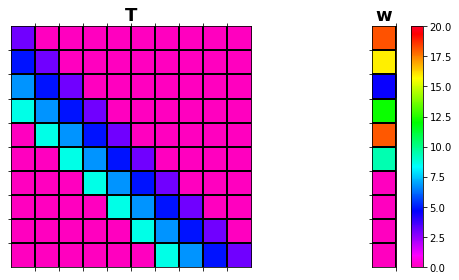

In [37]:
plt.figure(figsize=(7, 4))

plt.subplot(1,2,1)
plt.title('$\mathbf{T}$', fontsize=18)
plt.matshow(T, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{w}$', fontsize=18)
plt.matshow(np.reshape(w, (w.size,1)), fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[0.5], labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [38]:
# compute T'(equations 9 and 10)
DFT_first_column_T = np.sqrt(N)*np.dot(H, T[:,0])
Diagonal_matrix = np.diag(DFT_first_column_T)
H = dft(N, scale='sqrtn')
T_prime = np.linalg.multi_dot([np.conjugate(H), Diagonal_matrix, H]).real

In [39]:
# compare the original Toepliz matrix T and its approximated form
np.allclose(T, T_prime)

False

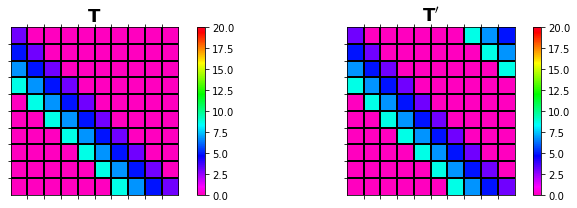

In [40]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.title('$\mathbf{T}$', fontsize=18)
plt.matshow(T, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{T}^{\prime}$', fontsize=18)
plt.matshow(T_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

Notice that, as in the previous case, only the lower triangle of these matrices are equal to each other.

In [41]:
np.allclose(np.tril(T), np.tril(T_prime))

True

There is something very special here. The differences between $\mathbf{T}$ and $\mathbf{T}^{\prime}$ are concentrated at the upper right corner. The remaining parts of these matrices are equal to each other. Another important thing is that, when multiplied by the vector $\mathbf{w}$, this upper corner coincides with the last null elements of $\mathbf{w}$. As a consequence:

$$
\mathbf{T} \mathbf{w} = \mathbf{T}^{\prime} \mathbf{w} \: .
$$

In [42]:
T_w = np.dot(T, w)

In [43]:
T_prime_w = np.dot(T_prime, w)

In [44]:
np.allclose(T_w, T_prime_w)

True

Consequently, we can use the same approach defined by [equation 7](#eq7) to compute the product $\mathbf{T} \mathbf{w}$ involving the particular matrix $\mathbf{T}$ and vector $\mathbf{w}$:

In [45]:
DFT_w = np.dot(H, w)

In [46]:
T_w_fft = np.dot(np.conjugate(H), DFT_first_column_T*DFT_w).real

In [47]:
np.allclose(T_w, T_w_fft)

True

<a id='sec3'></a>
## Arbitrary $N \times N$ Toeplitz matrices can be embedded into $2N \times 2N$ circulant matrices

Any Toeplitz matrix $\mathbf{T}$ can be embedded into a $2N \times 2N$ circulant matrix $\mathbf{C}$ with first column given by:

<a id='eq11'></a>
$$
\mathbf{c}_{0} = \begin{bmatrix}
t_{00} \\
t_{10} \\
\vdots \\
t_{(N-1)0} \\
0 \\
t_{0(N-1)} \\
t_{0(N-2)} \\
\vdots \\
t_{01}
\end{bmatrix} \: . \tag{11}
$$

Let consider $N = 4$. In this case, the Toeplitz matrix $\mathbf{T}$ and the embedding circulant matrix $\mathbf{C}$ are given by:

<a id='eq12a'></a>
$$
\mathbf{T} = \begin{bmatrix}
t_{00} & t_{01} & t_{02} & t_{03} \\
t_{10} & t_{00} & t_{01} & t_{02} \\
t_{20} & t_{10} & t_{00} & t_{01} \\
t_{30} & t_{20} & t_{10} & t_{00} \\
\end{bmatrix} \tag{12a}
$$

and

<a id='eq12b'></a>
$$
\mathbf{C} = \begin{bmatrix}
t_{00} & t_{01} & t_{02} & t_{03} &      0 & t_{30} & t_{20} & t_{10} \\
t_{10} & t_{00} & t_{01} & t_{02} & t_{03} &      0 & t_{30} & t_{20} \\
t_{20} & t_{10} & t_{00} & t_{01} & t_{02} & t_{03} &      0 & t_{30} \\
t_{30} & t_{20} & t_{10} & t_{00} & t_{01} & t_{02} & t_{03} &      0 \\
     0 & t_{30} & t_{20} & t_{10} & t_{00} & t_{01} & t_{02} & t_{03} \\
t_{03} &      0 & t_{30} & t_{20} & t_{10} & t_{00} & t_{01} & t_{02} \\
t_{02} & t_{03} &      0 & t_{30} & t_{20} & t_{10} & t_{00} & t_{01} \\
t_{01} & t_{02} & t_{03} &      0 & t_{30} & t_{20} & t_{10} & t_{00}
\end{bmatrix} \quad . \tag{12b}
$$

Notice that this embedding circulant matrix $\mathbf{C}$ ([equation 12b](#eq12b)) contains the original Toeplitz matrix $\mathbf{T}$ ([equation 12a](#eq12a)) in its upper left and lower right corners.

In [48]:
N = 10
col_T = np.linspace(3, 12, N)
row_T = np.linspace(12, 20, N)

In [49]:
T = toeplitz(col_T, row_T)

In [50]:
C_embedding = circulant(c=np.hstack([T[:,0], 0, T[0,-1:0:-1]]))

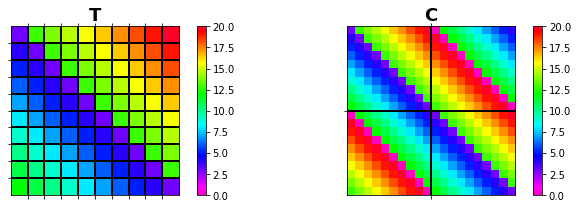

In [51]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.title('$\mathbf{T}$', fontsize=18)
plt.matshow(T, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.yticks(ticks=np.arange(N-1)+0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{C}$', fontsize=18)
plt.matshow(C_embedding, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[N-0.5], labels=[])
plt.yticks(ticks=[N-0.5], labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

<a id='sec3a'></a>
### Product of an arbitrary Toeplitz matrix $\mathbf{T}$ and an arbitrary vector $\mathbf{w}$

Let $\mathbf{w}$ be an arbitrary $N \times 1$ vector. The product of the $N \times N$ Toeplitz matrix $\mathbf{T}$ and vector $\mathbf{w}$ can be computed according to the algorithm below:

   * Use $\mathbf{T}$ to compute an $2N \times 2N$ embedding circulant matrix $\mathbf{C}$ (equations [11](#eq11), [12a](#eq12a) and [12b](#eq12b));
   * Pad the vector $\mathbf{w}$ with $N$ zeros to create a new vector $\mathbf{v}$;
   * Apply [equation 7](#eq7) to compute the product $\mathbf{C} \, \mathbf{v}$;
   * Retrieve the first $N$ elements of the resulting vector. They are the result of the product $\mathbf{T} \, \mathbf{w}$.

In [52]:
N = 21
col_T = 10*np.random.rand(N)
row_T = 10*np.random.rand(N)

In [53]:
T = toeplitz(col_T, row_T)

In [54]:
w = np.random.rand(N)

In [55]:
T_w = np.dot(T, w)

In [56]:
C_embedding = circulant(c=np.hstack([T[:,0], 0, T[0,-1:0:-1]]))

In [57]:
v_embedding = np.hstack([w, np.zeros(N)])

In [58]:
H2N = dft(2*N, scale='sqrtn')

In [59]:
DFT_v_embedding = np.dot(H2N, v_embedding)

In [60]:
lambda_C_embedding = np.sqrt(2*N)*np.dot(H2N, C_embedding[:,0])

In [61]:
C_v_embedding = np.dot(np.conjugate(H2N), lambda_C_embedding*DFT_v_embedding)

In [62]:
np.allclose(T_w, C_v_embedding[:N])

True